<a href="https://colab.research.google.com/github/LeonVillanueva/CoLab/blob/master/Google_CoLab_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 53kB/s 
     |████████████████████████████████| 501kB 42.6MB/s 
     |████████████████████████████████| 3.1MB 40.8MB/s 


In [0]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling1D, GaussianNoise, BatchNormalization, MaxPooling2D, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
from scipy import stats
import math
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
import re

> *https://www.gutenberg.org/files/4357/4357-h/4357-h.htm*

In [0]:
text = ['She flew down the stairs, found the basket and returned with it to the attic.',
        'Then she sat down before the brass-studded box and began trying one key after another in the curious old lock.',
        'Some were too large, but most were too small.']

max_vocab_size = 30000

tokenizer = Tokenizer (num_words = max_vocab_size)
tokenizer.fit_on_texts (text)
sequences = tokenizer.texts_to_sequences (text)

In [0]:
data = pad_sequences (sequences, padding='post')

> *https://www.kaggle.com/jrobischon/wikipedia-movie-plots*

In [8]:
!unzip movies.zip

Archive:  movies.zip
  inflating: wiki_movie_plots_deduped.csv  


In [0]:
df = pd.read_csv ('wiki_movie_plots_deduped.csv')

In [10]:
df.columns.values

array(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'], dtype=object)

In [0]:
df = df[(df['Genre'] != 'unknown')]

In [0]:
genres = df['Genre']

In [0]:
top_genres = genres.value_counts()[:10].index.tolist()

In [14]:
genres.value_counts()[:10]

drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

In [0]:
series = df [df['Genre'] == top_genres[0]].sample(460)

In [0]:
for i in range (1,len(top_genres)):
  series_b = df [df['Genre'] == top_genres[i]].sample(300)
  series = pd.concat((series, series_b), axis=0)

In [0]:
final = series[['Genre','Plot']]

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
from nltk.corpus import stopwords
import nltk

In [20]:
nltk.download ('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

> *https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/*

> *https://h1ros.github.io/posts/stemming-words-and-sentences/*

> *https://www.datacamp.com/community/tutorials/stemming-lemmatization-python*

In [0]:
def simplify (x):
  stop_words = stopwords.words ('english')
  words = re.sub(r'[^\w\s]','',x).lower().split(' ')
  words = [lemmatizer.lemmatize (word) for word in words if word not in stop_words]
  return words

In [0]:
txt = final.iloc[0]['Plot']

In [23]:
len (simplify (txt))

394

In [24]:
final['text'] = final['Plot'].apply (simplify)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
final['labels'] = final['Genre'].map (dict (zip (list(set(final['Genre'])), list(range(0,10)))))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
final.head()

,Genre,Plot,text,labels
15596,drama,The film opens with seventeen-year-old Michael...,"[film, open, seventeenyearold, michael, big, m...",7
22560,drama,He Dashang (Wu Gang) is a middle-aged childles...,"[dashang, wu, gang, middleaged, childless, inn...",7
20584,drama,Estranged sisters Isobel and Marion are forced...,"[estranged, sister, isobel, marion, forced, re...",7
11472,drama,The story is about a New York gangster who is ...,"[story, new, york, gangster, forced, go, run, ...",7
1699,drama,Olga (Aline MacMahon) runs an isolated gas sta...,"[olga, aline, macmahon, run, isolated, gas, st...",7


In [0]:
X_train, X_test, y_train, y_test = train_test_split (final['text'], final['labels'], test_size=0.10, random_state=23)

In [0]:
max_vocab_size = 42000

tokenizer = Tokenizer (num_words = max_vocab_size)
tokenizer.fit_on_texts (X_train)
sequence_train = tokenizer.texts_to_sequences (X_train)
sequence_test = tokenizer.texts_to_sequences (X_test)

In [0]:
word_to_idx = tokenizer.word_index

In [0]:
V = len (word_to_idx) # unique tokens

In [0]:
data_train = pad_sequences (sequence_train)
T = data_train.shape[1]
data_test = pad_sequences (sequence_test, maxlen=T, truncating='post')

In [32]:
data_train.shape, data_test.shape

((2844, 2781), (316, 2781))

In [0]:
D = 64 #Embedding Dimension

i = Input (shape=(T,))
x = Embedding (V+1, D) (i)
x = Dropout (0.5) (x)
x = LSTM (128, return_sequences=True) (x)
x = GlobalMaxPooling1D () (x)
x = Dropout (0.5) (x)
x = Dense (10, activation='softmax') (x)

In [0]:
model = Model (i, x)

In [0]:
adam = tf.keras.optimizers.Adam (learning_rate=0.005, decay=5e-6)

In [0]:
model.compile (optimizer=adam,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [37]:
epochs = 16

r = model.fit (data_train, y_train, validation_data=(data_test, y_test), epochs=epochs, batch_size=64)

Train on 2844 samples, validate on 316 samples
Epoch 1/16
2844/2844 [==============================] - 422s 148ms/sample - loss: 2.2942 - accuracy: 0.1371 - val_loss: 2.2741 - val_accuracy: 0.1424
Epoch 2/16
2844/2844 [==============================] - 396s 139ms/sample - loss: 2.1774 - accuracy: 0.2159 - val_loss: 2.0407 - val_accuracy: 0.2595
Epoch 3/16
2844/2844 [==============================] - 388s 136ms/sample - loss: 1.7736 - accuracy: 0.3797 - val_loss: 1.6728 - val_accuracy: 0.4367
Epoch 4/16
2844/2844 [==============================] - 387s 136ms/sample - loss: 1.1967 - accuracy: 0.5837 - val_loss: 1.5603 - val_accuracy: 0.4557
Epoch 5/16
2844/2844 [==============================] - 384s 135ms/sample - loss: 0.7037 - accuracy: 0.7704 - val_loss: 1.7766 - val_accuracy: 0.4494
Epoch 6/16
2844/2844 [==============================] - 388s 136ms/sample - loss: 0.4864 - accuracy: 0.8572 - val_loss: 1.8094 - val_accuracy: 0.4494
Epoch 7/16
2844/2844 [==============================]

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2781)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2781, 64)          3027712   
_________________________________________________________________
dropout (Dropout)            (None, 2781, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 2781, 128)         98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290  

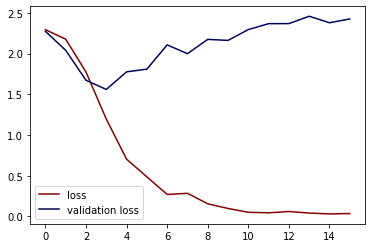

In [39]:
plt.plot (r.history['loss'], label='loss', color='#840000')
plt.plot (r.history['val_loss'], label='validation loss', color='#00035b')
plt.legend ()

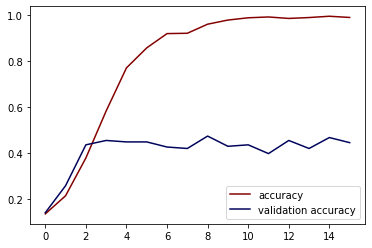

In [40]:
plt.plot (r.history['accuracy'], label='accuracy', color='#840000')
plt.plot (r.history['val_accuracy'], label='validation accuracy', color='#00035b')
plt.legend ()

In [0]:
data_pred = model.predict (data_test)

In [0]:
data_pred_class = []

for i in range (len (data_pred)):
  data_pred_class.append (np.argmax (data_pred[i]))


In [0]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=data_pred_class).numpy()

In [0]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

In [0]:
con_mat_df = pd.DataFrame(con_mat_norm)

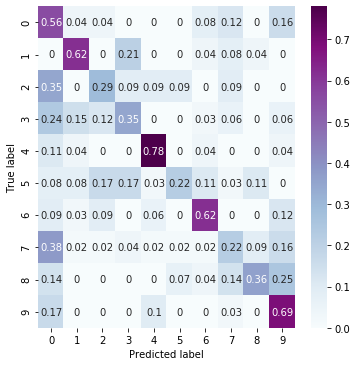

In [46]:
figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.BuPu)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Observations

1.   Even after Dropout of (0.5) the validation accuracy was at 45-50%.
2.   Need to add regularization for LSTM, given overfitting with 90%+ of training set.
3. Model definitely performed better with nltk lemma, and stopwords removal.

